In [1]:
import os.path
import sys
import logging

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import sklearn.svm
import sklearn.linear_model
import sklearn.ensemble

sys.path.append("../../")  # trick to import clairvoya from internal notebook directory
import clairvoya.runbench
import clairvoya.pulearning
import clairvoya.voya_plotter
import clairvoya.datasetup
import cPickle as pickle

%matplotlib inline

voya_logger = logging.getLogger('voya_notebook')
voya_logger.setLevel(logging.INFO)

# Run Conditions

In [2]:
train_num_pos = 100
train_num_unlab = 1000

test_num_all = 3000
test_num_pos_frac = 0.5

num_runs_per = 25

# gamma_range = np.arange(0.1, 1., 0.1)
gamma_range = (0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8)
# K_range = [1, 5, 10]

# Distributions
Gaussian1_mean = [0,0]
Gaussian2_mean = [1,1]

Gaussian1_cov = [[1, 0.5], [0.5, 1]]
Gaussian2_cov = [[1, -0.5], [-0.5, 1]]

In [3]:
# Generate Gaussian Functions
Gaussian1 = lambda n_samp: np.random.multivariate_normal(Gaussian1_mean, Gaussian1_cov, n_samp)
Gaussian2 = lambda n_samp: np.random.multivariate_normal(Gaussian2_mean, Gaussian2_cov, n_samp)

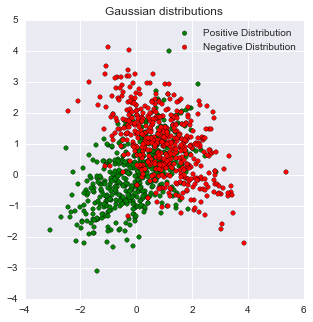

In [4]:
plot_samples = 500
plot_g1 = Gaussian1(plot_samples)
plot_g2 = Gaussian2(plot_samples)

fig = plt.figure(figsize=(5,5))
plt.scatter(plot_g1[:,0], plot_g1[:,1], c='green', label="Positive Distribution")
plt.scatter(plot_g2[:,0], plot_g2[:,1], c='red', label="Negative Distribution")
plt.title('Gaussian distributions')
plt.legend()

In [5]:
def generate_gaussian_features_array(Gaussian, num, label):
    data = Gaussian(num)
    label = np.ones(num) * label
    x_1 = data[:,0]
    x_2 = data[:,1]
    
    features_array = np.column_stack((label, label, x_1, x_2, x_1*x_2, x_1**2, x_2**2))
    return features_array

def generate_mixed_df(num_sample, frac_pos, global_label=None):
    num_pos = int(num_sample*frac_pos)
    num_neg = int(num_sample - num_pos)
    
    features_arr_pos = generate_gaussian_features_array(Gaussian1, num_pos, 1)
    features_arr_neg = generate_gaussian_features_array(Gaussian2, num_neg, 0)
    
    features_arr = np.vstack((features_arr_pos, features_arr_neg))
    mixed_df = pd.DataFrame(features_arr, columns=("fake_id", "label", "X_1", "X_2", "X_1 * X_2", "X_1**2", "X_2**2"))
    
    if global_label is not None:
        mixed_df['label'] = global_label
    
    return mixed_df

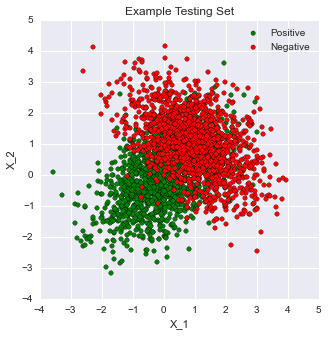

In [6]:
df = generate_mixed_df(test_num_all, 0.5)
fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
df[df["label"]==1].plot(kind="scatter", x="X_1", y="X_2", c='green', ax=ax1, label="Positive")
df[df["label"]==0].plot(kind="scatter", x="X_1", y="X_2", c='red', ax=ax1, label="Negative")
plt.title("Example Testing Set")

In [7]:
pd.value_counts(df[['label']].values.ravel()) # Sanity Check

1    1500
0    1500
dtype: int64

In [8]:
# Generate test data set
gamma = 0.5
train_unlabeled = generate_mixed_df(train_num_unlab, gamma, global_label=0)
train_positive = generate_mixed_df(train_num_pos, 1)
train_df = train_positive.append(train_unlabeled, ignore_index=True)
print pd.value_counts(train_df[['label']].values.ravel()) # Sanity Check
train_df.head()

0    1000
1     100
dtype: int64


,fake_id,label,X_1,X_2,X_1 * X_2,X_1**2,X_2**2
0,1,1,1.459145,1.223679,1.785526,2.129104,1.497391
1,1,1,-2.087440,-1.927408,4.023349,4.357404,3.714903
2,1,1,-0.562407,0.664752,-0.373861,0.316301,0.441895
3,1,1,1.787391,1.561507,2.791024,3.194767,2.438304
4,1,1,-1.638872,1.561426,-2.558979,2.685903,2.438052


In [9]:
test_df = generate_mixed_df(test_num_all, test_num_pos_frac)
print pd.value_counts(test_df[['label']].values.ravel()) # Sanity Check
test_df.head()

1    1500
0    1500
dtype: int64


,fake_id,label,X_1,X_2,X_1 * X_2,X_1**2,X_2**2
0,1,1,-0.810984,-0.368184,0.298591,0.657695,0.135559
1,1,1,1.013351,-0.459962,-0.466103,1.026881,0.211565
2,1,1,-1.687081,-0.856994,1.445819,2.846244,0.734439
3,1,1,2.883260,2.184930,6.299721,8.313188,4.773919
4,1,1,0.361372,1.668280,0.602869,0.130589,2.783156


# Configuring the benchmark

In [10]:
# clfs=('Logistic Regression', 'Gradient Boosting', 'LR_PosOnly(E&N2008)', 'Random Forrest', 'SVM_DoubleWeight(E&N2008)')
clfs = ('Bagging LR',)
auc_results = {clf_name:[] for clf_name in clfs}
for g_num, gamma in enumerate(gamma_range):
    voya_logger.info('Running classifiers for gamma={} ({}/{})'.format(gamma, g_num, len(gamma_range)))
    run_results = {clf_name:[] for clf_name in clfs}
    for i in xrange(num_runs_per):
        train_unlabeled = generate_mixed_df(train_num_unlab, gamma, global_label=0)
        train_positive = generate_mixed_df(train_num_pos, 1)
        train_df = train_positive.append(train_unlabeled, ignore_index=True)

        test_df = generate_mixed_df(test_num_all, test_num_pos_frac)


        config = {
            "test_df": test_df,  # instead of data_file, give split data
            "train_df": train_df,
            "out_path": None,
            "num_cores": 3,
            "verbosity": 0,
        }

        LR_estimator = sklearn.linear_model.LogisticRegression(C=0.4, penalty='l1')
        svc_estimator = sklearn.svm.SVC(C=2.5, kernel='linear', class_weight='auto', probability=True)

        classifiers = {
            'Bagging LR': sklearn.ensemble.BaggingClassifier(LR_estimator, n_estimators=200, max_samples=0.3)
#             'Logistic Regression': sklearn.linear_model.LogisticRegression(),
#             'Gradient Boosting': sklearn.ensemble.GradientBoostingClassifier(n_estimators=100,
#                                                                              learning_rate=0.1, max_depth=2),
#             'LR_PosOnly(E&N2008)': clairvoya.pulearning.PosOnly(LR_estimator, hold_out_ratio=0.2),
#             'SVM_DoubleWeight(E&N2008)': clairvoya.pulearning.PULearnByDoubleWeighting(svc_estimator), 
#             'Random Forrest': sklearn.ensemble.RandomForestClassifier(n_jobs=config["num_cores"]),
        }

        classifiers_gridparameters = { # Gridsearch off
            'Bagging LR': {'n_estimators': [30, 100], 'max_samples': [0.1, 0.3, 0.7, 1.0]},
            'LR_PosOnly(E&N2008)': None, #{'hold_out_ratio': [0.1, 0.3, 0.7, 1.0]},
            'Logistic Regression': {'fit_intercept': [True, False], 'C': [0.1, 0.3, 0.7, 1.0]},
            'Gradient Boosting': {"n_estimators": [30, 100], 'learning_rate': [0.1, 0.3, 0.7, 1.0], 'max_depth': [1, 3, 10]},
            'SVM_DoubleWeight(E&N2008)': None, # {'n_estimators': [30, 100], 'max_samples': [0.1, 0.3, 0.7, 1.0]},
            'Random Forrest': {"n_estimators": [30, 100], 'max_depth': [1, 3, 10]},
        }

        results_dict = clairvoya.runbench.run_benchmark(config, classifiers, classifiers_gridparameters)
        for clf_name in clfs:
            run_results[clf_name].append(results_dict[clf_name]['auc_score'])
    for clf_name in clfs:
        auc_results[clf_name].append(run_results[clf_name])

INFO:voya_notebook:Running classifiers for gamma=0.01 (0/11)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

In [ ]:
colors = seaborn.color_palette("Set2", 10)

plt.figure(figsize=(10,10))
for i, clf_name in enumerate(clfs):
    auc_scores = np.array(auc_results[clf_name])
    std_error = auc_scores.std(axis=1) / np.sqrt(num_runs_per)
    plt.errorbar(gamma_range, auc_scores.mean(axis=1), yerr=std_error, label=clf_name,
                 c=colors[i], capthick=1)
    plt.scatter(gamma_range, auc_scores.mean(axis=1), c=colors[i], lw=0)
    
    plt.ylabel('AUC Score')
    plt.xlabel('Frac Unlabelled Positives')
    plt.legend()
    
    title = "Train P {}, U {}, Test {}, Testfrac {}".format(
        train_num_pos, train_num_unlab, test_num_all, test_num_pos_frac)
    plt.title(title)
    plt.savefig('plots/{}.png'.format(title))

In [ ]:
# Easy results save for now
with open(os.path.join('result_data', 'BGGaussian' + title + '.pickle'), 'wb') as f:
    pickle.dump(auc_results, f)